Finite-Volume Method

Most popular method in computational fluid dynamics (everyone loves it)

* FVM discretizations are very general and are very flexible

* FVM gives a conservative discretization automatically by directly using the conservation laws in integral form.

Conservation:
$$\frac{\partial}{\partial t} \int_{\text{cv}} e dV + \oint_{\text{cs}} \vec{F} \cdot d\vec{A} = 0$$

Why not make the control volume itself our computational cell?

$$e_i = \frac{1}{\Delta x} int_{x_i - \Delta x/2}^{x_i + \Delta x/2} e(x,t) dx$$

If we know the flux terms at the boundaries, the general conservation law gives:

$$\frac{\partial}{\partial t} e_i + \frac{1}{\Delta x} \left[ F(x_{i + 1/2},t) - F(x_{i-1/2},t)\right] = 0$$

Godunov's Method (1959)

Uses integral form of the conservation laws and a piecewise constant representation of the solution

Use Riemann solution at each cell boundary (what a smart guy)

Need to solve Riemann from $t$ to $\Delta t$ one on each cell boundary

$$F_{i+1/2} = \frac{1}{\Delta t} \int_{t^n}^{t^{n+1}} F(e(x_{i+1/2},t)) dt$$

Rusanov flux aka Lax-Friedrichs flux

$$F_{i+1/2} = \frac{1}{2} [F(e_L) + F(e_R)] - \frac{1}{2} max |F'(e)| (e_R - e_L)$$

F'(e) is the Jacobian of the flux function and max|F'(e)| is the local propagation speed of the fastest traveling wave.

The Riemann solutions at each cell boundary don't interact if $max|F'(e)| \leq \frac{\Delta x}{\Delta t}$ which leads to:
$$F_{i+1/2} = \frac{1}{2} \left( F(e_i) + F(e_{i+1}) - \frac{\Delta x}{\Delta t} (e_{i+1} - e_i) \right)$$

In [5]:
from traffic import rho_red_light, computeF

In [6]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [7]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 101
nt = 30
dx = 4.0/(nx-2)

rho_in = 5.
rho_max = 10.

V_max = 1.

x = numpy.linspace(0,4,nx-1)

rho = rho_red_light(nx-1, rho_max, rho_in)

In [8]:
def animate(data):
    x = numpy.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

In [9]:
def godunov(rho, nt, dt, dx, rho_max, V_max):
    """Computes the solution with the Godunov scheme using the Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho : array of floats
        Density at current time-step
    nt : int
        Number of time steps
    dt : float
        Time-step size
    dx : float
        Mesh spacing
    rho_max : float
        Maximum allowed car density
    V_max : float
        Speed limit
        
    Returns
    -------
    rho_n : array of floats
        Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:] #can't do i+1/2 indices so cell boundary
        rho_minus = rho.copy() #arrays at index i are at location i+1/2
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) + computeF(V_max, rho_max, rho_plus) + dx/dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [10]:
sigma = 1.0
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in) # make sure that u is set to our expected initial conditions
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)


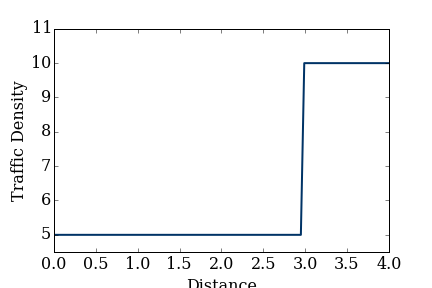
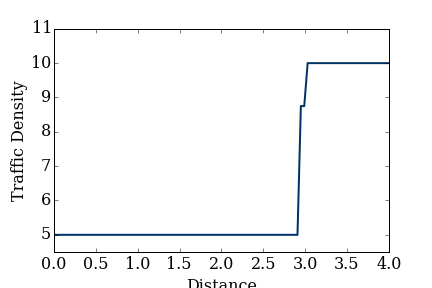
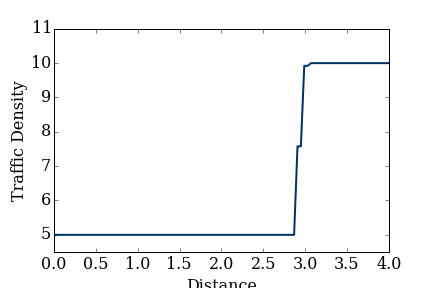
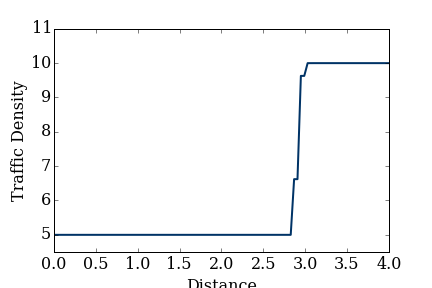
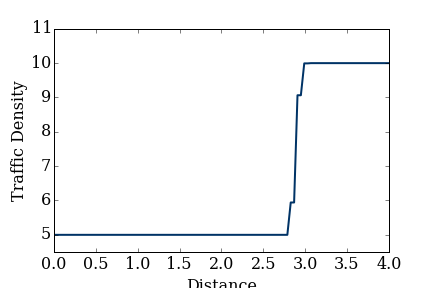
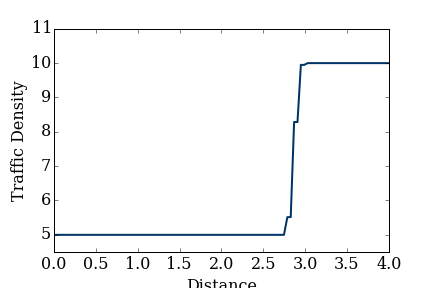
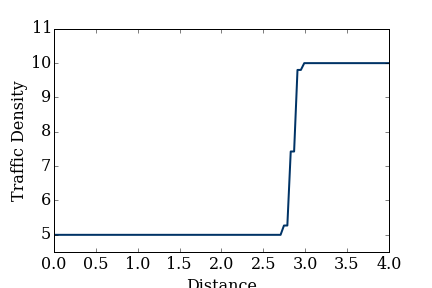
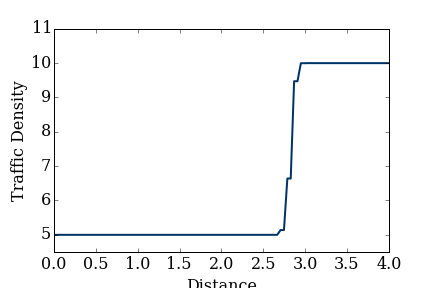
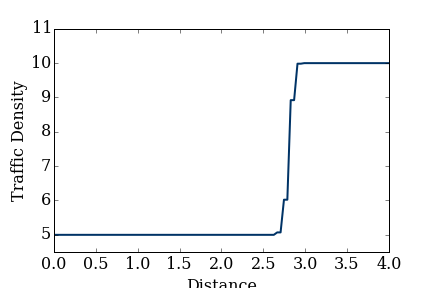
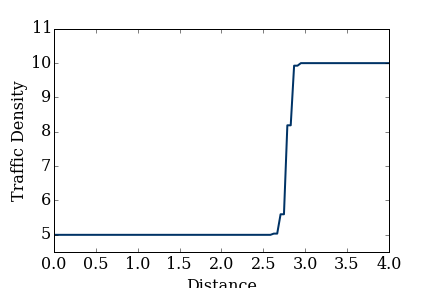
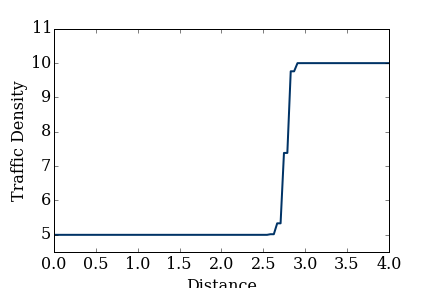
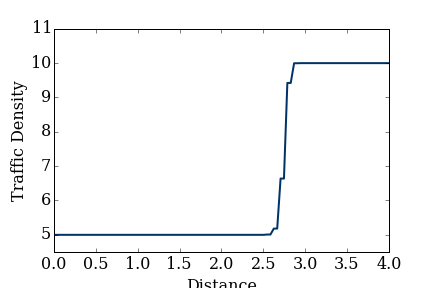
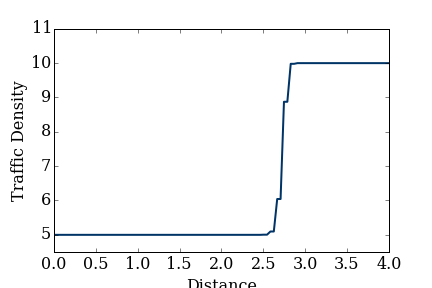
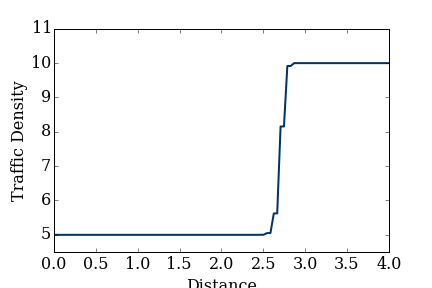
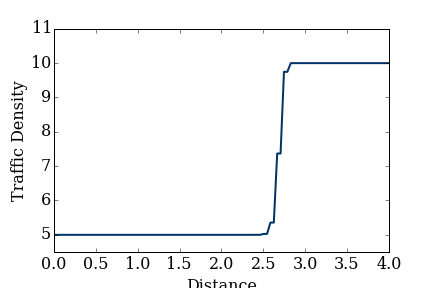
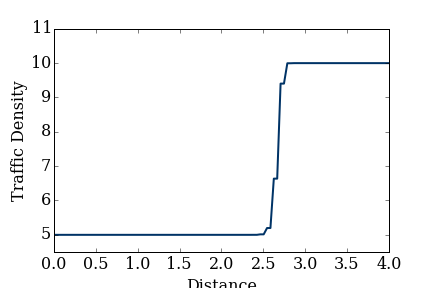
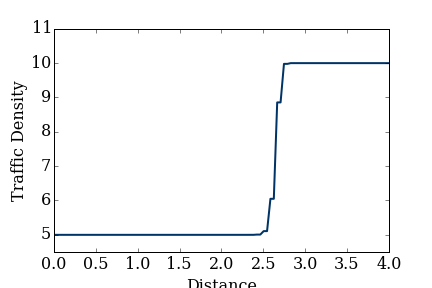
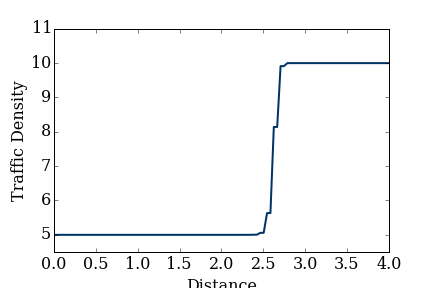
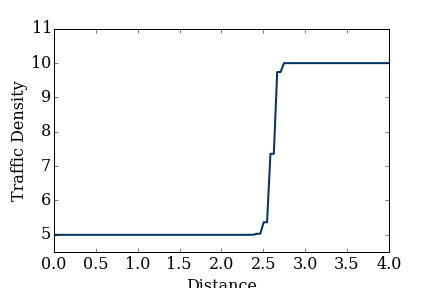
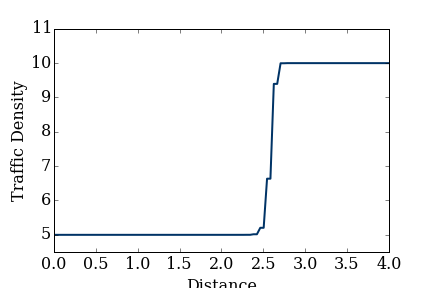
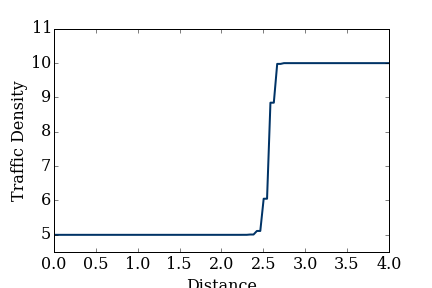
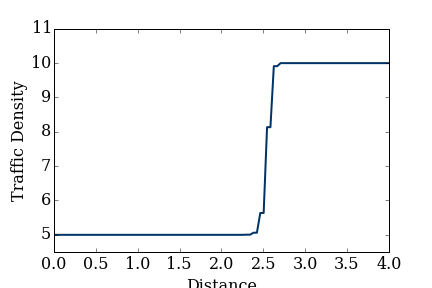
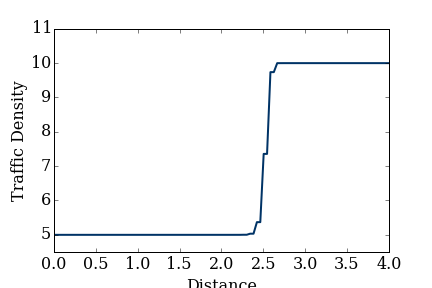
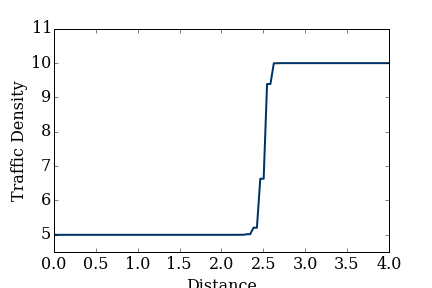
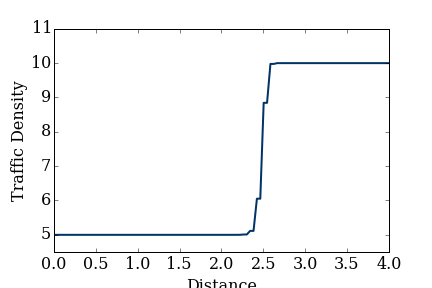
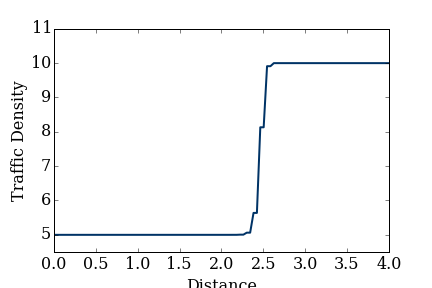
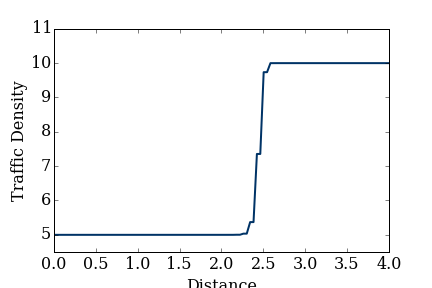
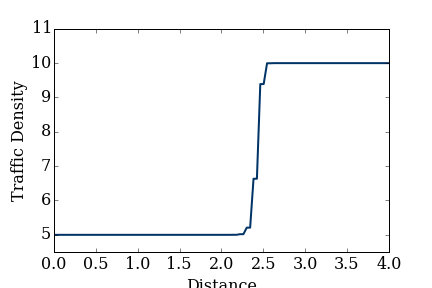
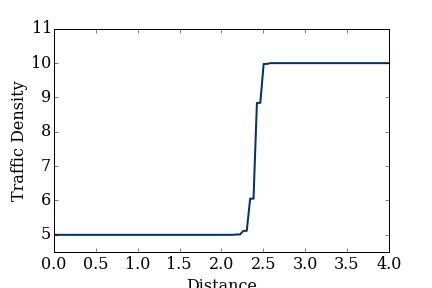
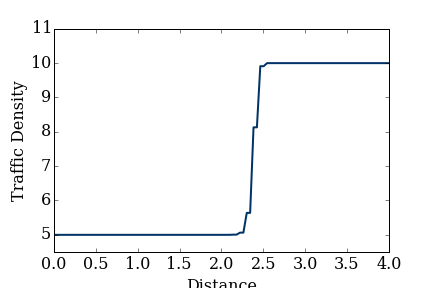

In [11]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366',lw=2);

anim = animation.FuncAnimation(fig, animate, frames = rho_n, interval=50)
display_animation(anim, default_mode='once')

# MUSCL schemes (1979)

Godunov's method is first-order accurate, which is not appropriate for hyperbolic conservation laws, due to high numerical diffusion.

## Reconstruction in space

The piecewise linear reconstruction consists of representing the solution inside each cell with a straight line.  Define the cell representation as:
$$e(x) = e_i + \sigma_i (x-x_i)$$

$\sigma_i$ is the slope of the approximation within the cell and $e_i$ is the Godunov cell average.  $\sigma_i = 0$ gives Godunov's method.

Standard central diff gives:
$$\sigma_i = \frac{e_{i+1} - e_{i-1}}{2\Delta x}$$
But this leads to oscillations near shocks.  Gibbs oscillations will always appear unless we use constant reconstruction.  The slope then has to be modified or limited near shocks.

The easiest way to limit the slope is to compute one sided slopes.

$$\Delta e^- = \frac{e_i - e_{i-1}}{\Delta x}, \quad \Delta e^+ = \frac{e_{i+1} - e_i}{\Delta x}$$

Minmod slope 
$$\begin{align}
    \sigma_i & = \text{minmod} (\Delta e^-, \Delta e^+) \\
    & = \begin{cases} \min(\Delta e^-, \Delta e^+) & \text{ if } \Delta e^-,
    \Delta e^+ > 0 \\
    \max(\Delta e^-, \Delta e^+) & \text{ if } \Delta e^-, \Delta e^+ < 0 \\
    0 & \text{ if } \Delta e^-, \Delta e^+ \leq 0
    \end{cases}
   \end{align}$$
   
Use the smallest one-sided slope in magnitude unless the slopes have different sign, then it uses constant reconstruction which is Godunov's

After the mimod is calculated, we can get the values at the interfaces between cells.
$$e_{i-1/2}^R = e_i - \sigma_i \frac{\Delta x}{2}$$
$$e_{i+1/2}^L = e_i - \sigma_i \frac{\Delta x}{2}$$

Where $e^R$ and $e^L$ are the local interpolated values of the conserved quantity immediately to the right and left of the cell boundary

$e_{i-1/2}^R \text{ and } e_{i+1/2}^L$ are the local values of the solution at opposite cell boundaries.

However when the local flux is calculated at the cell boundaries, the local solutions are used.
$$F_{i+1/2} = f(e_{i+1/2}^L,e_{i+1/2}^R)$$

In [12]:
def minmod(e, dx):
    """
    Compute the minmod approximation to the slope
    
    Parameters
    ----------
    e : array of float
        input data
    dx : float
        spacestep
        
    Returns
    -------
    sigma : array of float
        minmod slope
    """
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    # The following is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

## Evolution in time

Aiming for second-order accuracy in space.  Need a method to evolve the ordinary diff eq forwards in time:
$$\frac{\partial}{\partial t} e_i + \frac{1}{\Delta x} [F(x_{i+1/2},t) - F(x_{i-1/2},t)] = 0$$

A second order Runge-Kutta with special characteristics gives:
$$e_i^* = e_i^n + \frac{\Delta t}{\Delta x} (F_{i-1/2}^n - F_{i+1/2}^n)$$
$$e_i^{n+1} = \frac{1}{2} e_i^n + \frac{1}{2} \left( e_i^* + \frac{\Delta t}{\Delta x} (F_{i-1/2}^* - F_{i+1/2}^*) \right)$$

Rusanov flux:
$$F_{i+1/2} = \frac{1}{2} [F(e_L) + F(e_R)] - \frac{1}{2} max|F'(e)| (e_R - e_L)$$

With the interpolated values of e at the cell boundaries we can get a more accurate Rusanov flux.  At cell boundary i + 1/2 it is:
$$F_{i+1/2} = \frac{1}{2} \left( F(e_{i+1/2}^L) + F(e_{i+1/2}^R) - \frac{\Delta x}{\Delta t} (e_{i+1/2}^R - e_{i+1/2}^L) \right)$$

In [13]:
def muscl(rho, nt, dt, dx, rho_max, V_max):
    """Computes the solution with the MUSCL scheme using the Lax-Friedrichs flux, RK2 in time and minmod slope limiting.
    
    Parameters
    ----------
    rho : array of floats
        Density at current time-step
    nt : int
        Number of time steps
    dt : float
        Time-step size
    dx : float
        Mesh spacing
    rho_max : float
        Maximum allowed car density
    V_max : float
        Speed limit
        
    Returns
    -------
    rho_n : array of floats
        Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)
    
    for t in range(1,nt):
        
        sigma = minmod(rho,dx) #calculate minmod slope
        
        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux i = i + 1/2
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt * (rho_right[1:] - rho_left[:-1]))
        
        #rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        sigma = minmod(rho_star, dx) #calculate minmod slope
        
        #reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt * (rho_right[1:] - rho_left[:-1]))
        
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx * (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n
    

In [15]:
sigma = 1.
dt = sigma*dx/V_max
rho = rho_red_light(nx-1, rho_max, rho_in) # make sure that u is set to our expected initial conditions
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)


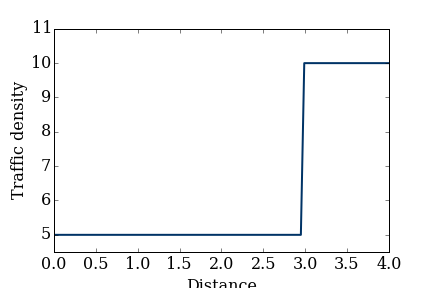
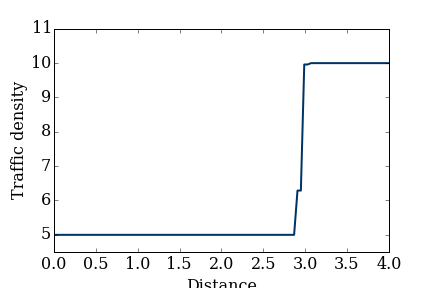
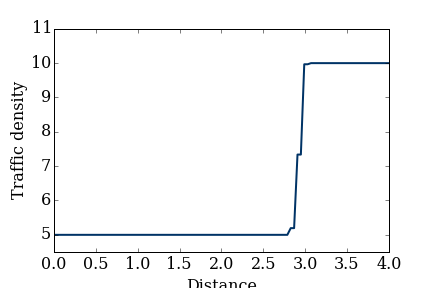
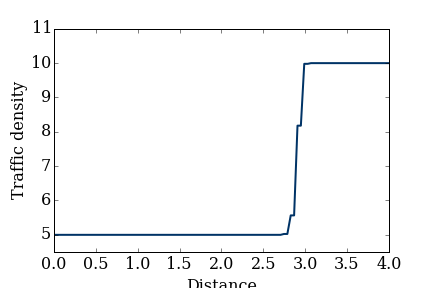
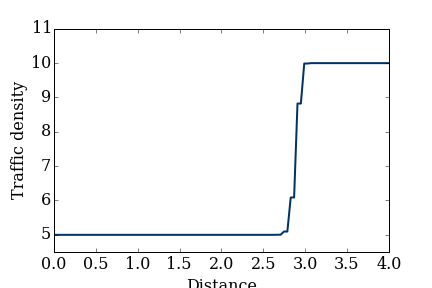
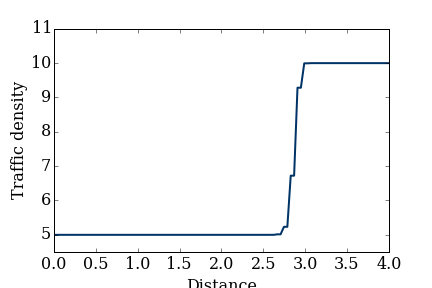
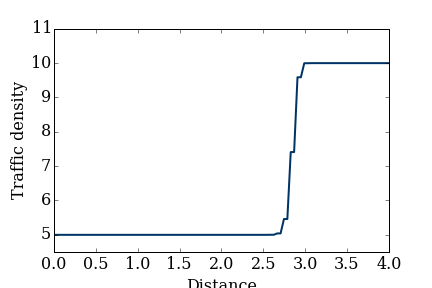
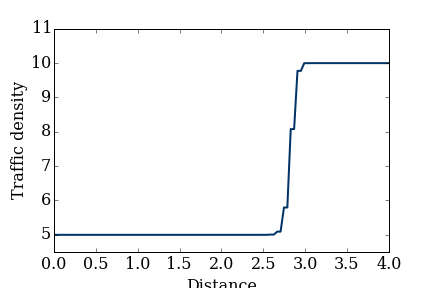
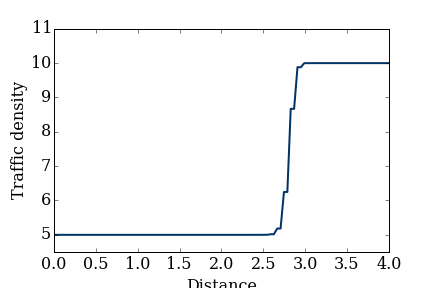
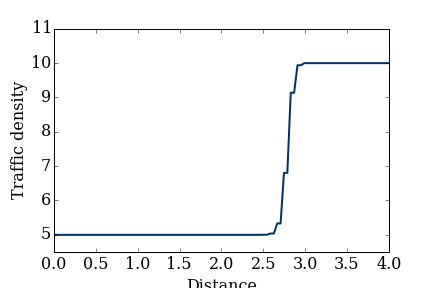
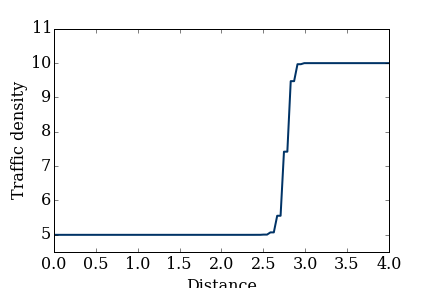
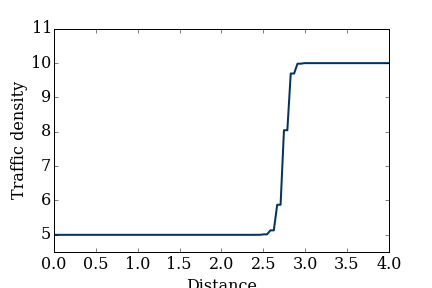
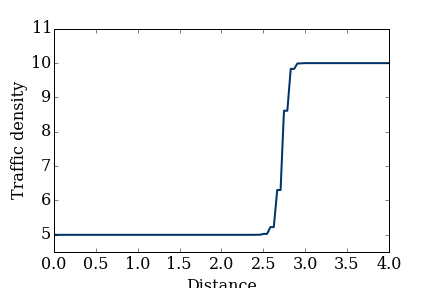
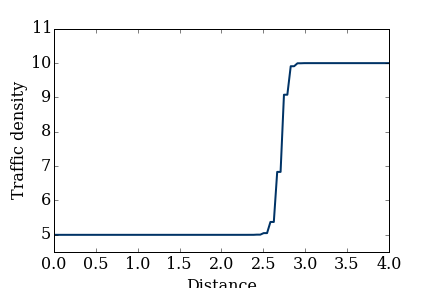
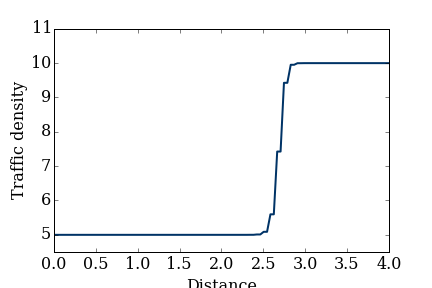
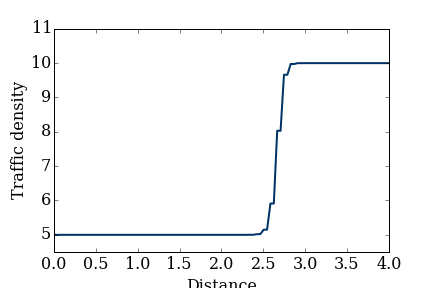
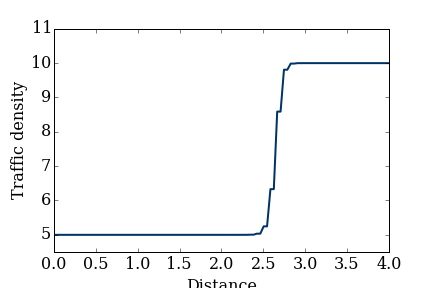
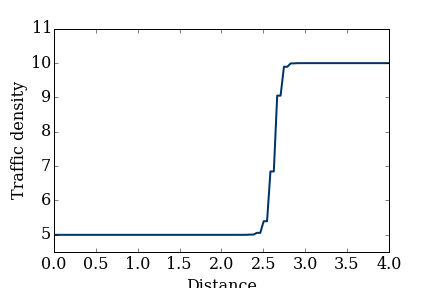
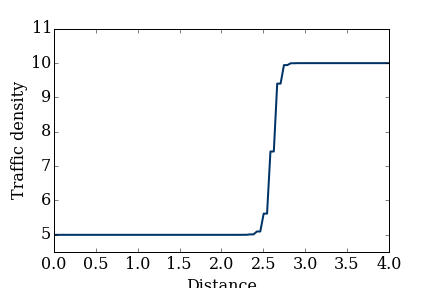
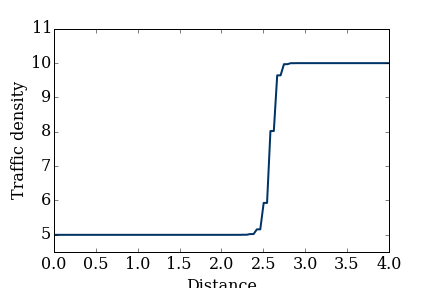
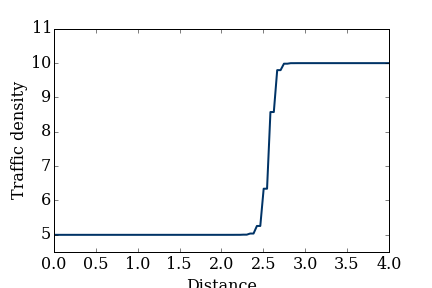
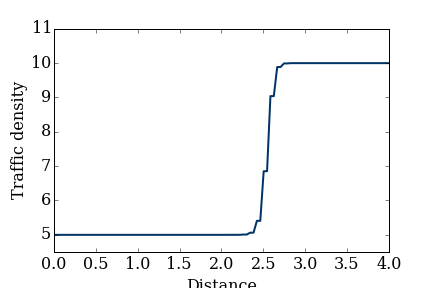
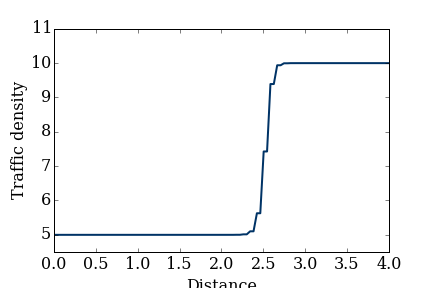
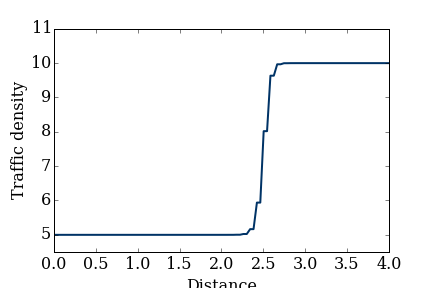
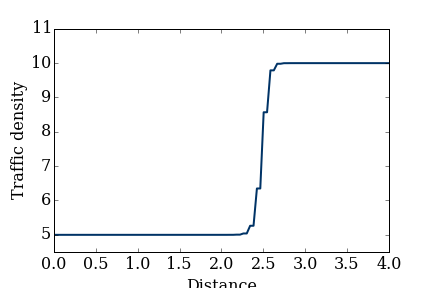
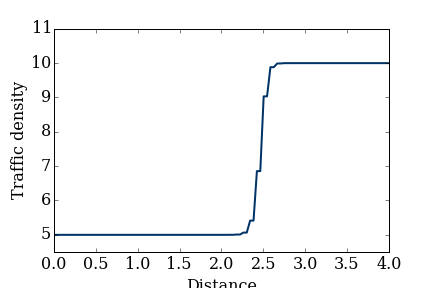
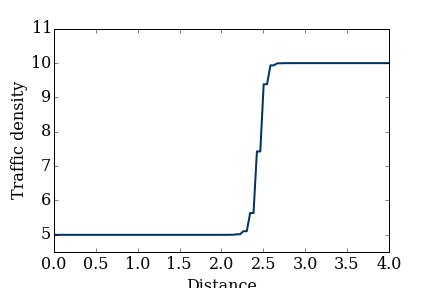
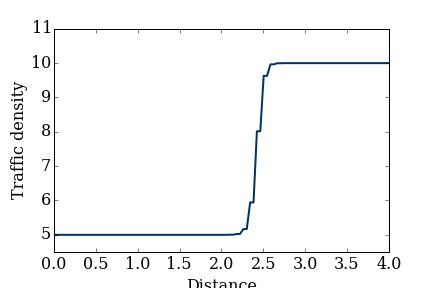
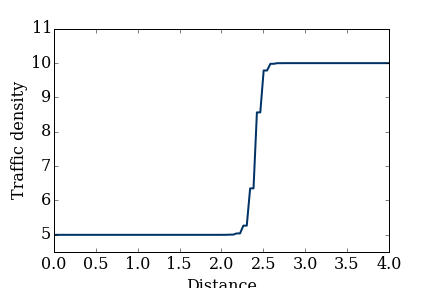
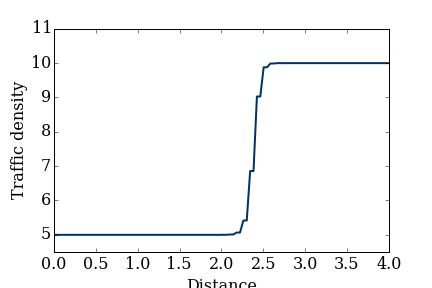

In [16]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366',lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval =50)
display_animation(anim, default_mode='once')